# **TSLA Stock Regression Models**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import scipy.stats as ss
import statsmodels as smt
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model, model_selection, metrics

In [2]:
TSLA = pd.read_csv('TSLA_Final.csv')
TSLA.drop(columns = 'Close', inplace = True)

In [3]:
TSLA.head()

,Date,Open,High,Low,Adj Close,Volume,Mkt-RF,SMB,HML,RF,Yest_Close,stock_return,SMA_20,SMA_50,EMA_12,EMA_26,MACD,RSI,ADS_Index
0,2017-01-04,14.316667,15.200000,14.287333,15.132667,168202500,0.79,0.95,-0.16,0.002,14.466000,0.046085,15.132667,15.132667,15.132667,15.132667,0.000000,100.000000,0.147667
1,2017-01-05,15.094667,15.165333,14.796667,15.116667,88675500,-0.21,-0.88,-0.79,0.002,15.132667,-0.001057,15.124667,15.124667,15.130205,15.131481,-0.001276,0.000000,0.127719
2,2017-01-06,15.128667,15.354000,15.030000,15.267333,82918500,0.29,-0.66,-0.31,0.002,15.116667,0.009967,15.172222,15.172222,15.151302,15.141545,0.009757,91.024248,0.108194
3,2017-01-09,15.264667,15.461333,15.200000,15.418667,59692500,-0.37,-0.29,-1.04,0.002,15.267333,0.009912,15.233833,15.233833,15.192435,15.162072,0.030363,95.477309,0.051808
4,2017-01-10,15.466667,15.466667,15.126000,15.324667,54900000,0.16,0.88,0.44,0.002,15.418667,-0.006096,15.252000,15.252000,15.212778,15.174116,0.038662,71.686831,0.033339


Text(0.5, 1.0, 'TSLA Stock Price')

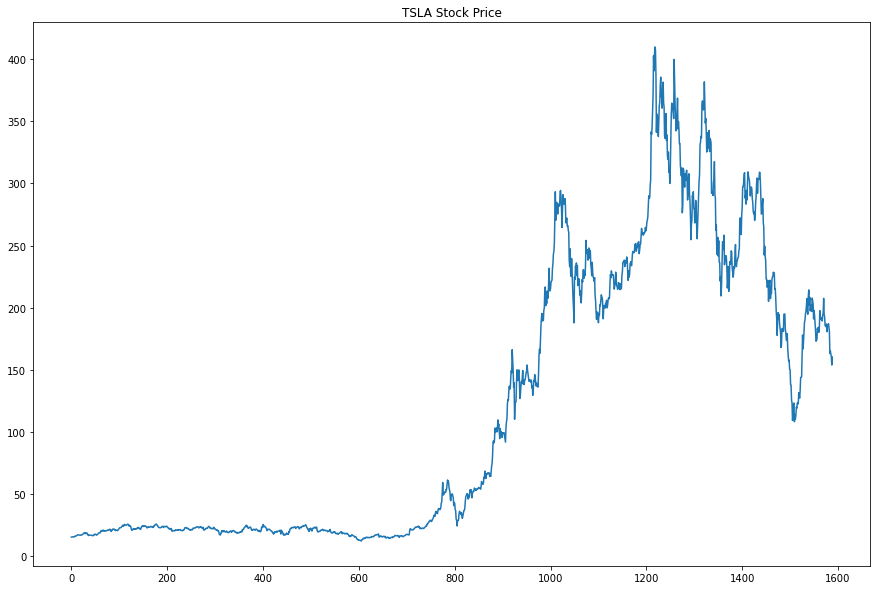

In [4]:
plt.figure(figsize = (15, 10))
plt.plot(TSLA['Adj Close'])
plt.title("TSLA Stock Price")

In [5]:
n = TSLA.shape[0]
test_ratio = 0.8

TSLA_train = TSLA[:int(n*test_ratio)]
TSLA_test = TSLA[int(n*test_ratio):]

In [6]:
TSLA_DateIndex =  TSLA.copy()
TSLA_DateIndex.set_index('Date', inplace = True)

In [7]:
X = TSLA_DateIndex.drop(columns = 'Adj Close')
y = TSLA_DateIndex['Adj Close']

In [8]:
TSLA_train.set_index('Date', inplace = True)
TSLA_test.set_index('Date', inplace = True)

X_train, X_test = TSLA_train.drop(columns = 'Adj Close'), TSLA_test.drop(columns = 'Adj Close')
y_train, y_test = TSLA_train['Adj Close'], TSLA_test['Adj Close']

## Lasso

In [9]:
# Lasso with Cross Validation
model_lassoCV = linear_model.LassoCV(fit_intercept = True, cv = 20).fit(X_train, y_train)
model_lassoCV_filtered = X_train.columns[np.abs(model_lassoCV.coef_) != 0.0]

print('The important feature as per Lasso regularization with cross validation:', model_lassoCV_filtered[0])
print('The optimum alpha as per Lasso regularization with cross validataion:', model_lassoCV.alpha_)

The important feature as per Lasso regularization with cross validation: Volume
The optimum alpha as per Lasso regularization with cross validataion: 45240610.38272715


In [10]:
# GridSearch
alpha_range = np.logspace(-4, 4, 100)
model_lasso_grid = linear_model.Lasso()

lasso_grid_search = model_selection.GridSearchCV(model_lasso_grid, param_grid = {'alpha': alpha_range}, cv = 20)
lasso_grid_search.fit(X_train, y_train)

# optimal alpha value
lasso_optimal_alpha = lasso_grid_search.best_params_['alpha']
print('The optimal value of alpha as per Grid Search is:', lasso_optimal_alpha)

The optimal value of alpha as per Grid Search is: 5.857020818056673


In [11]:
# Lasso with optimal alpha
model_lasso = linear_model.Lasso(lasso_optimal_alpha)
model_lasso.fit(X_train, y_train)

model_lasso_filtered = X_train.columns[np.abs(model_lasso.coef_) != 0.0]
print('The selected features by lasso Regularization\n', list(model_lasso_filtered))

The selected features by lasso Regularization
 ['Open', 'High', 'Low', 'Volume', 'RSI']


In [12]:
# Fitting the OLS
X_train_lasso = X_train[model_lasso_filtered]
X_test_lasso = X_test[model_lasso_filtered]

model_lasso_OLS = sm.OLS(y_train, X_train_lasso, normalize = True).fit()
print(model_lasso_OLS.summary())

                                 OLS Regression Results                                
Dep. Variable:              Adj Close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.389e+06
Date:                Sat, 29 Jul 2023   Prob (F-statistic):                        0.00
Time:                        21:22:38   Log-Likelihood:                         -2558.6
No. Observations:                1271   AIC:                                      5127.
Df Residuals:                    1266   BIC:                                      5153.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [13]:
lasso_pval = pd.DataFrame(model_lasso_OLS.pvalues).reset_index()

lasso_pval.rename(columns = {'index': 'feature', 0: 'pValue'}, inplace = True)
lasso_pval['pValue'] = lasso_pval['pValue'].apply(lambda x: "{:f}".format(x))
lasso_pval['pValue'] = lasso_pval['pValue'].astype(float)
lasso_pval[lasso_pval['pValue'] <= 0.05]

,feature,pValue
0,Open,0.0
1,High,0.0
2,Low,0.0


In [14]:
y_train_pred_lasso = model_lasso_OLS.predict(X_train_lasso)
train_r2_lasso = round(metrics.r2_score(y_train, y_train_pred_lasso), 2)
print('The R2 of training set for Lasso is:', round(metrics.r2_score(y_train, y_train_pred_lasso), 2))
print('The MSE of training set for Lasso is:', (str(round(metrics.mean_squared_error(y_train, y_train_pred_lasso), 2)) + '%'))

y_test_pred_lasso = model_lasso_OLS.predict(X_test_lasso)
test_r2_lasso = round(metrics.r2_score(y_test, y_test_pred_lasso), 2)

p_lasso = X_test_lasso.shape[1]  # Number of columns
n_lasso = len(y_test_pred_lasso)  # Number of records

# Calculate the adjusted R-squared
adjusted_r2_lasso = 1 - (1 - test_r2_lasso) * ((n_lasso - 1) / (n_lasso - p_lasso - 1))

print('\nThe R2 of testing set for Lasso is:', round(metrics.r2_score(y_test, y_test_pred_lasso), 2))
print('The Adjusted R2 of testing set for Lasso is:', round(adjusted_r2_lasso, 2))
print('The MSE of testing set for Lasso is:', (str(round(metrics.mean_squared_error(y_test, y_test_pred_lasso), 2)) + '%'))

# Correlation between y predicted and y
corr_lasso = ss.pearsonr(y_test_pred_lasso, y_test)[0]
print('\nThe correlation of Lasso model is:', round(corr_lasso, 2))

The R2 of training set for Lasso is: 1.0
The MSE of training set for Lasso is: 3.28%

The R2 of testing set for Lasso is: 1.0
The Adjusted R2 of testing set for Lasso is: 1.0
The MSE of testing set for Lasso is: 13.65%

The correlation of Lasso model is: 1.0


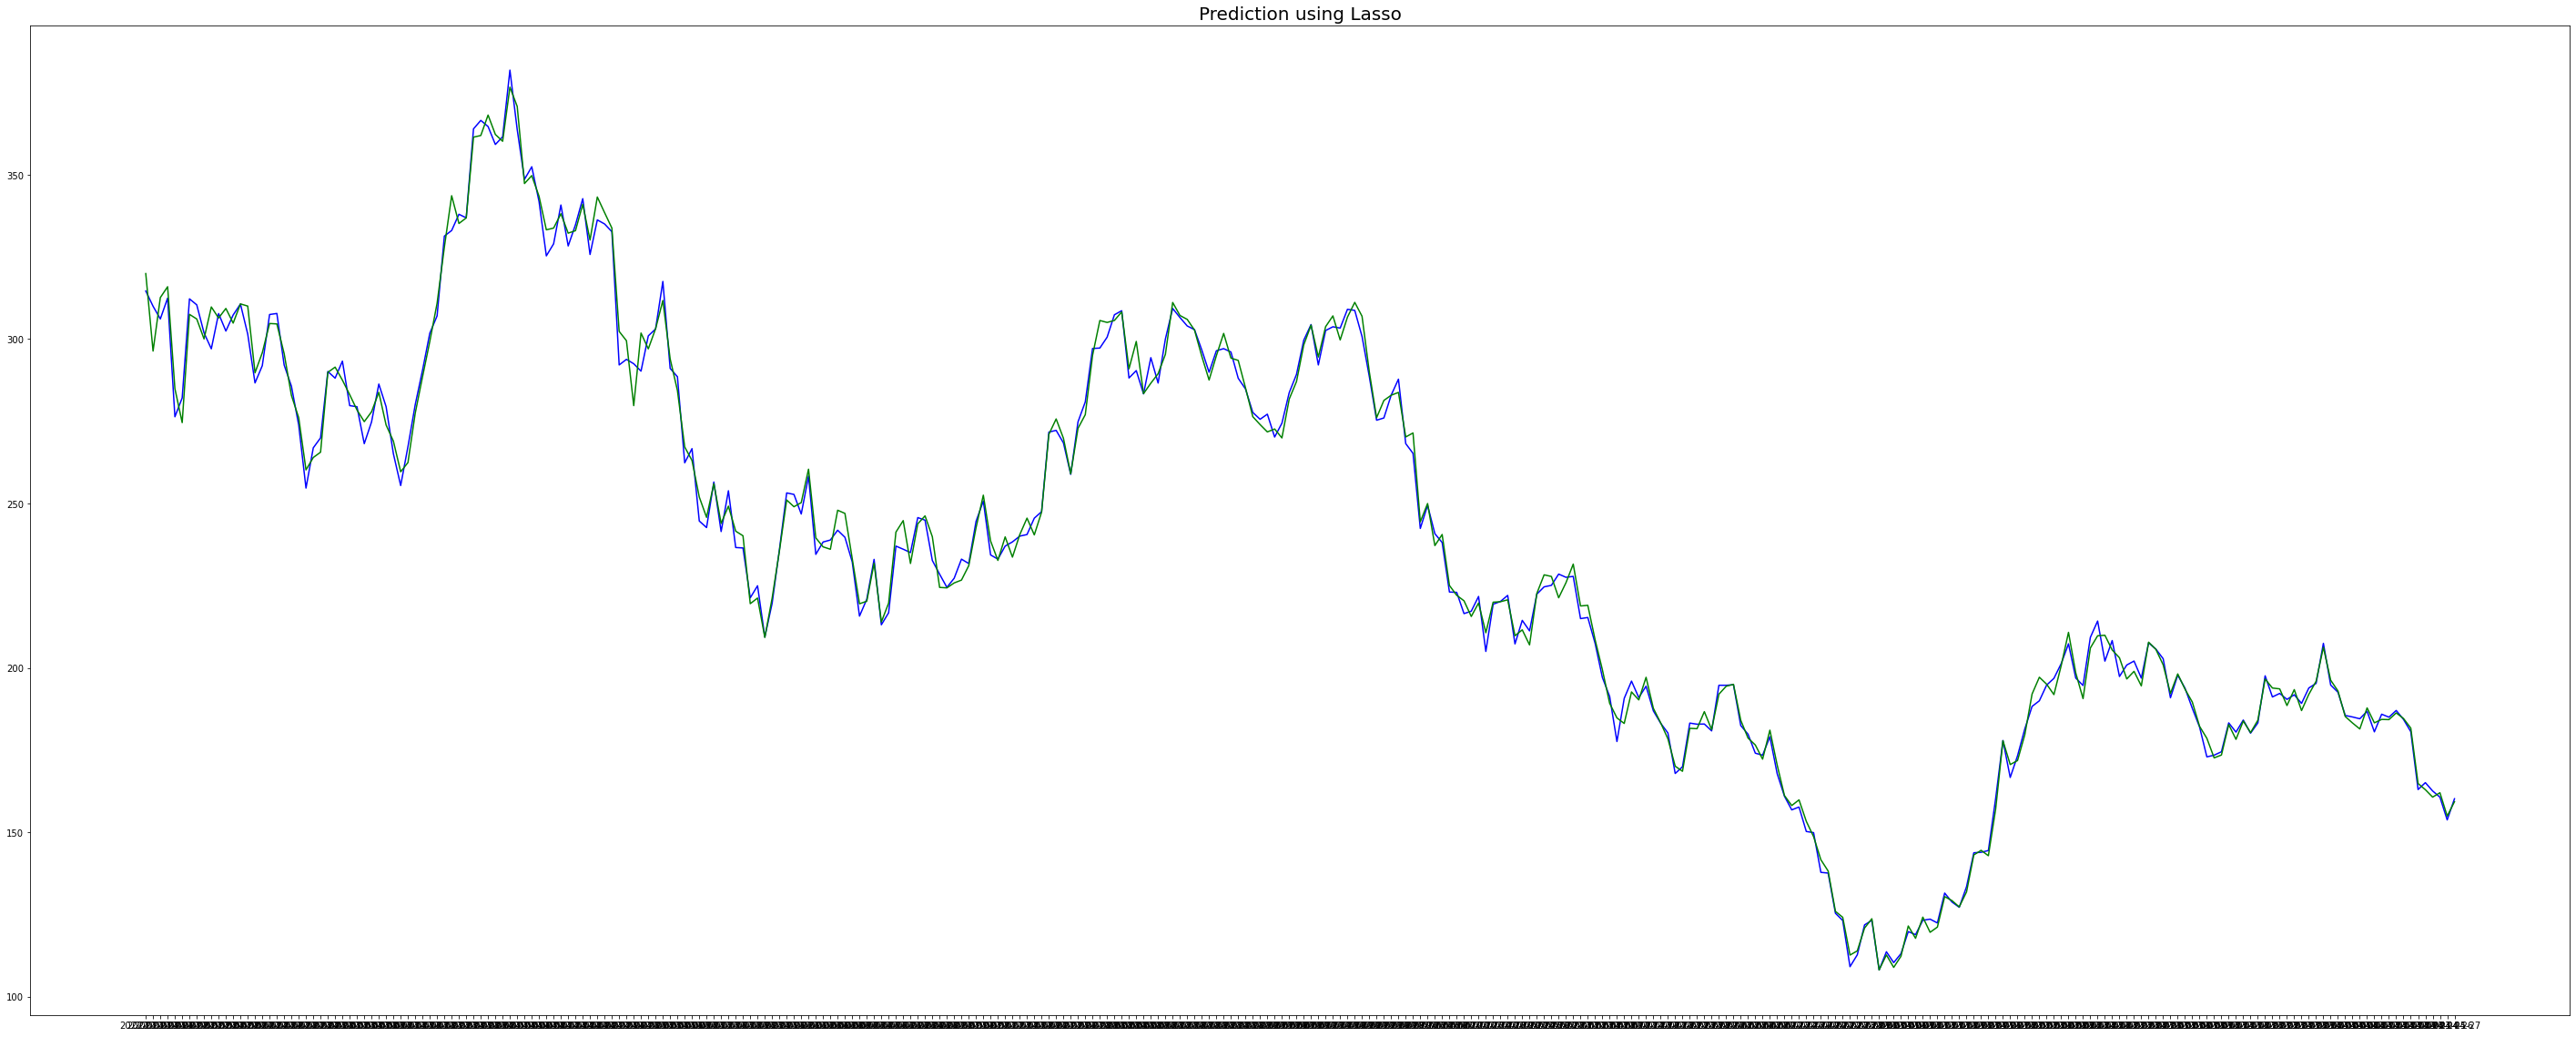

In [16]:
plt.figure(figsize = (50, 20))
plt.plot(y_test, color = 'blue', label = 'actual')
plt.plot(y_test_pred_lasso, color = 'green', label = 'prediction')
plt.title("Prediction using Lasso", fontdict= {'fontsize': 20})
plt.show()

In [17]:
import numpy as np
def MAPE(y_test,y_test_pred_lasso):
    mape = np.mean(np.abs((y_test - y_test_pred_lasso)/y_test))*100
    return mape

In [18]:
Lasso_MAPE = MAPE(y_test,y_test_pred_lasso)
print("MAPE value: ",Lasso_MAPE)
Accuracy = 100 - Lasso_MAPE
print('Accuracy of Lasso Regression: {:0.2f}%.'.format(Accuracy))

MAPE value:  1.1770969728560654
Accuracy of Lasso Regression: 98.82%.


## Ridge

In [19]:
# Ridge with Cross Validation
model_RidgeCV = linear_model.RidgeCV(fit_intercept = True, cv = 20).fit(X_train, y_train)
model_RidgeCV_filtered = X_train.columns[np.abs(model_RidgeCV.coef_) != 0.0]
print('The importatnt feature as per Lasso regularization with cross validation:', model_RidgeCV_filtered[0])
print('The optimum alpha as per Lasso regularization with cross validataion:', model_RidgeCV.alpha_)

The importatnt feature as per Lasso regularization with cross validation: Open
The optimum alpha as per Lasso regularization with cross validataion: 10.0


In [20]:
# GridSearch
alpha_range = np.logspace(-4, 4, 100)
model_ridge_grid = linear_model.Ridge()

lasso_ridge_search = model_selection.GridSearchCV(model_ridge_grid, param_grid = {'alpha': alpha_range}, cv = 20)
lasso_ridge_search.fit(X_train, y_train)

# optimal alpha value
ridge_optimal_alpha = lasso_ridge_search.best_params_['alpha']
print('The optimal value of alpha as per Grid Search is:', ridge_optimal_alpha)

The optimal value of alpha as per Grid Search is: 613.5907273413176


In [21]:
# Lasso with optimal alpha
model_ridge = linear_model.Ridge(ridge_optimal_alpha)
model_ridge.fit(X_train, y_train)

model_ridge_filtered = X_train.columns[np.abs(model_ridge.coef_) > 0.001]
print('The selected features by Ridge Regularization\n', list(model_ridge_filtered))

The selected features by Ridge Regularization
 ['Open', 'High', 'Low', 'Mkt-RF', 'SMB', 'HML', 'Yest_Close', 'stock_return', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD', 'RSI', 'ADS_Index']


In [22]:
# Fitting the OLS
#X_train_lasso = sm.add_constant(X_train[model_lasso_filtered])
X_train_ridge = X_train[model_ridge_filtered]
X_test_ridge = X_test[model_ridge_filtered]

model_ridge_OLS = sm.OLS(y_train, X_train_ridge, normalize= True).fit()
print(model_ridge_OLS.summary())

                                 OLS Regression Results                                
Dep. Variable:              Adj Close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.237e+05
Date:                Sat, 29 Jul 2023   Prob (F-statistic):                        0.00
Time:                        21:31:27   Log-Likelihood:                         -2408.6
No. Observations:                1271   AIC:                                      4845.
Df Residuals:                    1257   BIC:                                      4917.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [23]:
ridge_pval = pd.DataFrame(model_ridge_OLS.pvalues).reset_index()

ridge_pval.rename(columns = {'index': 'feature', 0: 'pValue'}, inplace = True)
ridge_pval['pValue'] = ridge_pval['pValue'].apply(lambda x: "{:f}".format(x))
ridge_pval['pValue'] = ridge_pval['pValue'].astype(float)
ridge_pval[ridge_pval['pValue'] <= 0.05]

,feature,pValue
0,Open,0.000000
1,High,0.000000
2,Low,0.000000
3,Mkt-RF,0.000023
4,SMB,0.005234
5,HML,0.000024
6,Yest_Close,0.000205
7,stock_return,0.000000
8,SMA_20,0.021668
10,EMA_12,0.000000


In [24]:
y_train_pred_ridge = model_ridge_OLS.predict(X_train_ridge)
train_r2_ridge = round(metrics.r2_score(y_train, y_train_pred_ridge), 2)
print('The R2 of training set for Ridge is:', round(metrics.r2_score(y_train, y_train_pred_ridge), 2))
print('The MSE of training set for Ridge is:', (str(round(metrics.mean_squared_error(y_train, y_train_pred_ridge), 2)) + '%'))

y_test_pred_ridge = model_ridge_OLS.predict(X_test_ridge)
test_r2_ridge = round(metrics.r2_score(y_test, y_test_pred_ridge), 2)

p_ridge = X_test_ridge.shape[1]  # Number of columns
n_ridge = len(y_test_pred_ridge)  # Number of records

# Calculate the adjusted R-squared
adjusted_r2_ridge = 1 - (1 - test_r2_ridge) * ((n_ridge - 1) / (n_ridge - p_ridge - 1))
print('\nThe R2 of testing set for Ridge is:', round(metrics.r2_score(y_test, y_test_pred_ridge), 2))
print('The Adjusted R2 of testing set for Ridge is:', round(adjusted_r2_ridge, 2))
print('The MSE of testing set for Ridge is:', (str(round(metrics.mean_squared_error(y_test, y_test_pred_ridge), 2)) + '%'))

# Correlation between y predicted and y
corr_ridge = ss.pearsonr(y_test_pred_ridge, y_test)[0]
print('\nThe correlation of Ridge model is:', round(corr_ridge, 2))

The R2 of training set for Ridge is: 1.0
The MSE of training set for Ridge is: 2.59%

The R2 of testing set for Ridge is: 1.0
The Adjusted R2 of testing set for Ridge is: 1.0
The MSE of testing set for Ridge is: 10.18%

The correlation of Ridge model is: 1.0


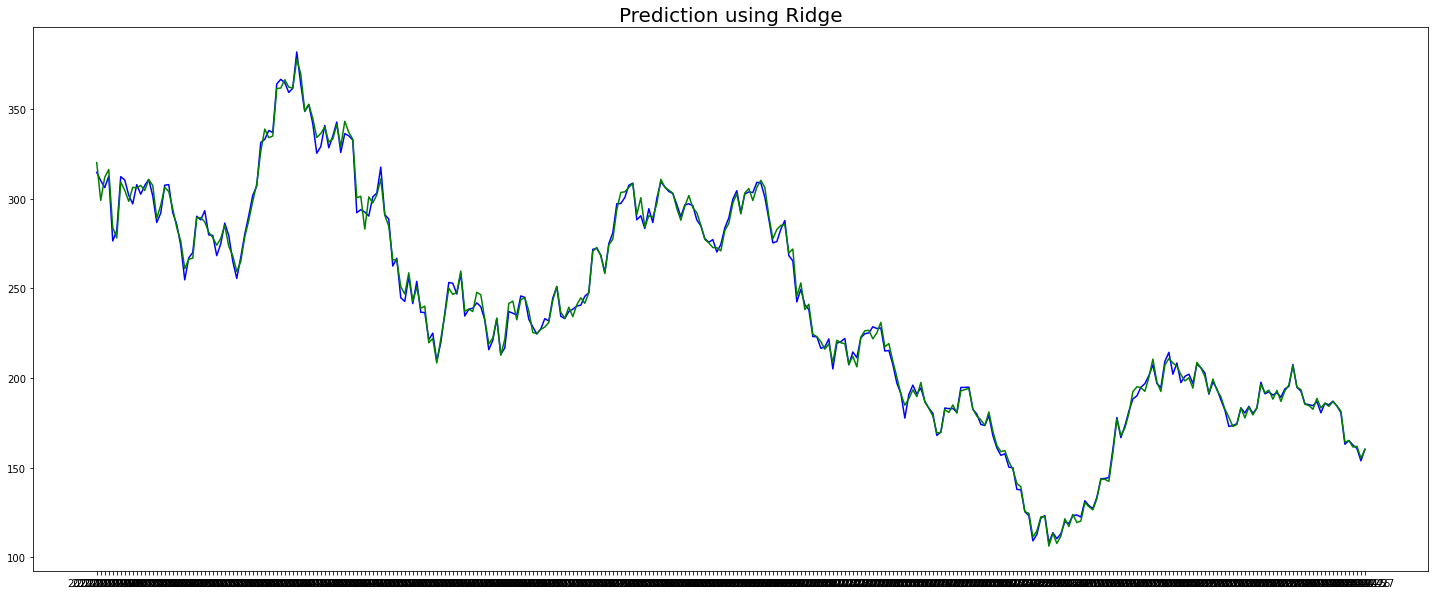

In [26]:
plt.figure(figsize=(25, 10))
plt.plot(y_test, color = 'blue', label = 'actual')
plt.plot(y_test_pred_ridge, color = 'green', label = 'prediction')
plt.title("Prediction using Ridge", fontdict= {'fontsize': 20})
plt.show()

## Least Angle Regression - LARS

In [27]:
# Lasso with Cross Validation
model_larsCV = linear_model.LarsCV(fit_intercept = True, cv = 20).fit(X_train, y_train)
model_larsCV_filtered = X_train.columns[np.abs(model_larsCV.coef_) >= 0.001]
print('The importatnt feature as per Lasso regularization with cross validation:', model_larsCV_filtered[0])

The importatnt feature as per Lasso regularization with cross validation: Open


In [28]:
# Fitting the OLS
X_train_lars = X_train[model_larsCV_filtered]
X_test_lars = X_test[model_larsCV_filtered]

model_lars_OLS = sm.OLS(y_train, X_train_lars, normalize = True).fit()
print(model_lars_OLS.summary())

                                 OLS Regression Results                                
Dep. Variable:              Adj Close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.817e+05
Date:                Sat, 29 Jul 2023   Prob (F-statistic):                        0.00
Time:                        21:37:35   Log-Likelihood:                         -2408.6
No. Observations:                1271   AIC:                                      4847.
Df Residuals:                    1256   BIC:                                      4924.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [29]:
lars_pval = pd.DataFrame(model_lars_OLS.pvalues).reset_index()

lars_pval.rename(columns = {'index':'feature', 0: 'pValue'}, inplace = True)
lars_pval['pValue'] = lars_pval['pValue'].apply(lambda x: "{:f}".format(x))
lars_pval['pValue'] = lars_pval['pValue'].astype(float)
lars_pval[lars_pval['pValue'] <= 0.05]

,feature,pValue
0,Open,0.000000
1,High,0.000000
2,Low,0.000000
3,Mkt-RF,0.000023
4,SMB,0.005351
5,HML,0.000025
7,Yest_Close,0.000206
8,stock_return,0.000000
9,SMA_20,0.021659
11,EMA_12,0.002456


In [30]:
y_train_pred_lars = model_lars_OLS.predict(X_train_lars)
train_r2_lars = round(metrics.r2_score(y_train, y_train_pred_lars), 2)
print('The R2 of training set for LARS is:', round(metrics.r2_score(y_train, y_train_pred_lars), 2))
print('The MSE of training set for LARS is:', (str(round(metrics.mean_squared_error(y_train, y_train_pred_lars), 2)) + '%'))

y_test_pred_lars = model_lars_OLS.predict(X_test_lars)
test_r2_lars = round(metrics.r2_score(y_test, y_test_pred_lars), 2)

p_lars = X_test_lars.shape[1]  # Number of columns
n_lars = len(y_test_pred_lars)  # Number of records

# Calculate the adjusted R-squared
adjusted_r2_lars = 1 - (1 - test_r2_lars) * ((n_lars - 1) / (n_lars - p_lars - 1))
print('\nThe R2 of testing set for LARS is:', round(metrics.r2_score(y_test, y_test_pred_lasso), 2))
print('The Adjusted R2 of testing set for LARS is:', round(adjusted_r2_lars, 2))
print('The MSE of testing set for LARS is:', (str(round(metrics.mean_squared_error(y_test, y_test_pred_lars), 2)) + '%'))

# Correlation between y predicted and y
corr_lars = ss.pearsonr(y_test_pred_lars, y_test)[0]
print('\nThe correlation of Least Angle Regression model is:', round(corr_lars, 2))

The R2 of training set for LARS is: 1.0
The MSE of training set for LARS is: 2.59%

The R2 of testing set for LARS is: 1.0
The Adjusted R2 of testing set for LARS is: 1.0
The MSE of testing set for LARS is: 10.18%

The correlation of Least Angle Regression model is: 1.0


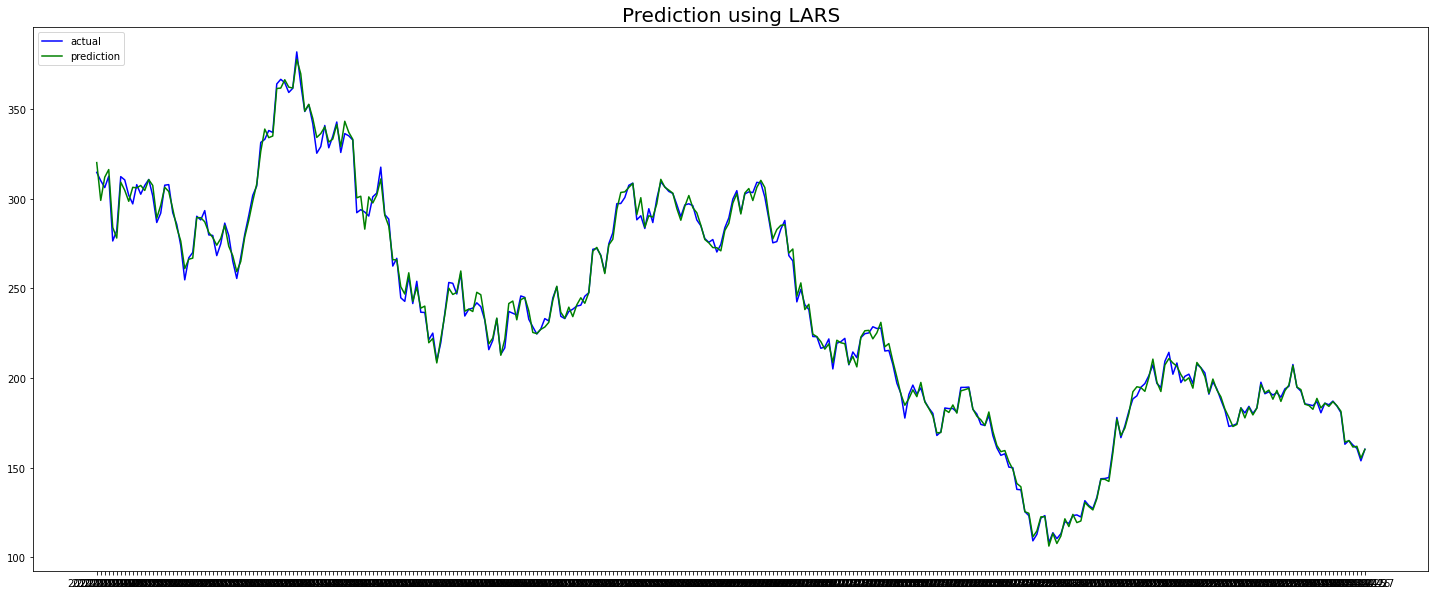

In [31]:
plt.figure(figsize = (25, 10))
plt.plot(y_test, color = 'blue', label = 'actual')
plt.plot(y_test_pred_lars, color = 'green', label = 'prediction')
plt.title("Prediction using LARS", fontdict= {'fontsize': 20})
plt.legend(loc = 'upper left')
plt.show()

## Comparison of Ridge, Lasso, LARS

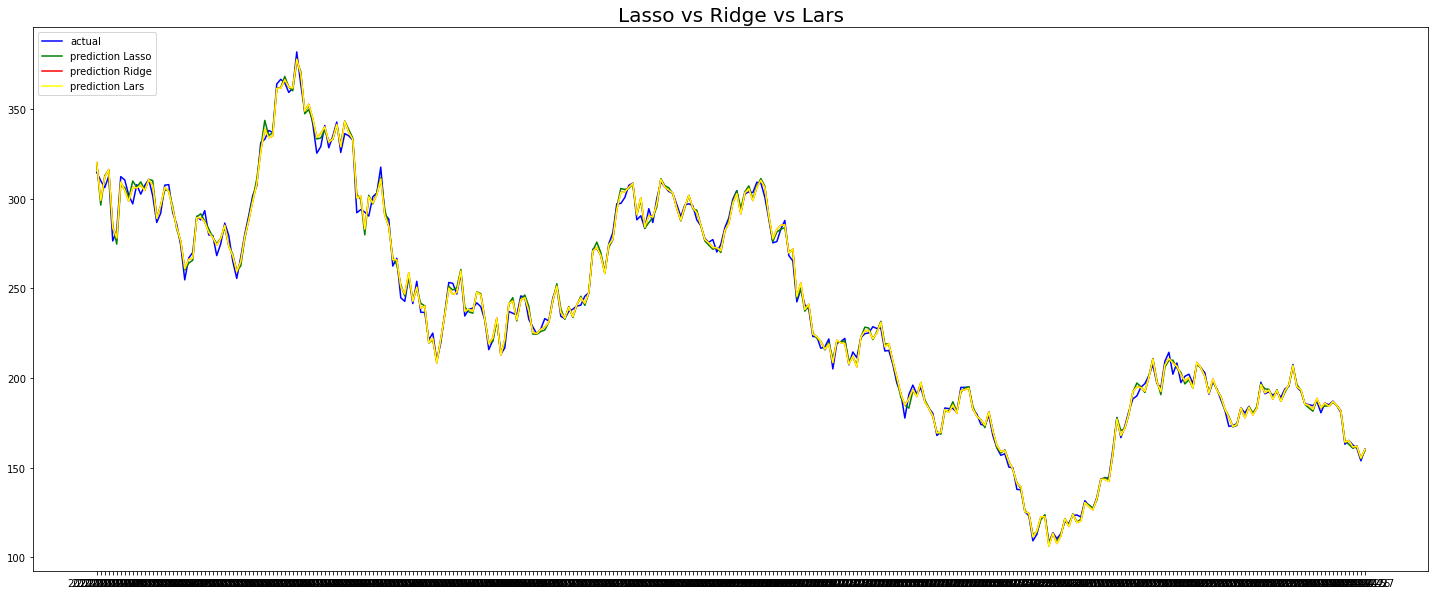

In [32]:
plt.figure(figsize = (25, 10))
plt.plot(y_test, color = 'blue', label = 'actual')
plt.plot(y_test_pred_lasso, color = 'green', label = 'prediction Lasso')
plt.plot(y_test_pred_ridge, color = 'red', label = 'prediction Ridge')
plt.plot(y_test_pred_lars, color = 'yellow', label = 'prediction Lars')
plt.title("Lasso vs Ridge vs Lars", fontdict= {'fontsize': 20})
plt.legend(loc = 'upper left')
plt.show()